## Todo


- ✔️ check other out_quants (higher frequencies, damping ratios, etc.)
- ✔️ find good epsilon for zetas and damp_freqs
- ✔️ evaluate intp_errors, exceed and undershot for frf, zetas, damp_freqs
- ✔️ check most recent ale samples manually to see what's going on

- ✔️ also do something similar for nearestND interpolator
- ✔️increase number of propositions for add_mass and b and ???
    - ✔️damp_freqs is sensitive to add_mass (1 proposition), ice_mass (1 proposition), (b 1 and t 2)
    - ✔️zetas is sensititive to zeta (and dD but that is aleatory) (4 propositions)
    - ✔️frfs is sensitive to all of them depending on frequency line and response dof
    - ✔️-> should have two propositions on add_mass (40,50)
- ✔️ estimate runtime for all 13717 aleatory samples with nearest and rbf interpolators and decide 
  - ✔️ whether performance can be improved further
  - ✔️ whether to implement distributed imperfection estimation
  - ✔️ 1 sample around 30 s -> 3062 samples -> 1531 minutes -> 26 hours (114 hours -> 5 days)
  - ✔️ Vectorize wrapper: 1 sample around 12 s @ 4 CPUs (rbf) -> 3062 samples -> 612 (2743) minutes -> 10:30 (45) hours (2 days) ->  (2078 out_quants -> 659 days @ 1 node, 32 days @ 20 nodes)

- ✔️ test val_samp_prim
- batch process already propagated ale samples

- for exemplary ret_names do
  - estimate_imp (with rbf)
  - optimize_inc
  - draw plots
- test repeat with nearest and compare
- repeat for all ret_names and selected ret_inds
- finish remaining ale samples

In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
import logging
sys.path.append("/usr/wrk/people9/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.stats.qmc

import ray

from uncertainty.polymorphic_uncertainty import PolyUQ
from uncertainty.data_manager import DataManager

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

In [3]:
from UQ_Modal_Beam import mapping_function, mapping_pass, test_interpolation, vars_definition, est_imp, opt_inc, est_stoch

##### Uncertainty Modeling

In [4]:
vars_ale, vars_epi, arg_vars = vars_definition()

##### Sampling

In [5]:
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 13717 # N_mcs = 1e6 = N_mcs_ale * N_mcs_epi
N_mcs_epi = 729 # = 3^6 = 2.56^n_imp ~ 3^n_imp -> cover every corner and midpoints in a full-factorial design (but distributed)
use_dm = True
result_dir = '/usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/'

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'))

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz


## Evaluate RBF interpolation parameters

In [5]:
ret_name = ['damp_freqs','zetas','frf'][1]
if ret_name == 'frf':
    ret_ind = {'frequencies':126, 'space':1}
else:
    ret_ind = {'modes':13}
    
ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'        
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

poly_uq.load_state(os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz'))
if ret_name == 'damp_freqs':
    poly_uq.out_valid = [np.nanmin(poly_uq.out_samp),np.nanmax(poly_uq.out_samp)]

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/zetas-13/polyuq_prop.npz


In [6]:
plt.close('all')
# %%snakeviz -t
if True:
    logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
    logger.setLevel(level=logging.DEBUG)
    poly_uq.N_mcs_ale=np.random.randint(20,3062)
    poly_uq.estimate_imp(
        interp_fun='rbf',
        opt_meth='genetic',
        plot_res=False,
        plot_intp=False,
        intp_err_warn = 0,
        extrp_warn = 0,
        start_ale = poly_uq.N_mcs_ale - 2,
        kernel='gaussian',
        epsilon={'frf':4,'zetas':2,'damp_freqs':2}[ret_name]
    )
    print([var for var in poly_uq.vars_ale if var.primary] + list(poly_uq.vars_imp))
    for n_ale in range(poly_uq.N_mcs_ale - 2,poly_uq.N_mcs_ale):
        for i_hyc in range(len(poly_uq.imp_hyc_foc_inds)):
            print(n_ale, i_hyc)
            print(poly_uq.val_samp_prim[n_ale,i_hyc,:,0])
            print(poly_uq.val_samp_prim[n_ale,i_hyc,:,1])

#     poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_imp.npz'))
else:
    poly_uq.load_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_imp.npz'))
    


KeyboardInterrupt



Error in callback <function flush_figures at 0x7f6d5c68f5b0> (for post_execute):



KeyboardInterrupt



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
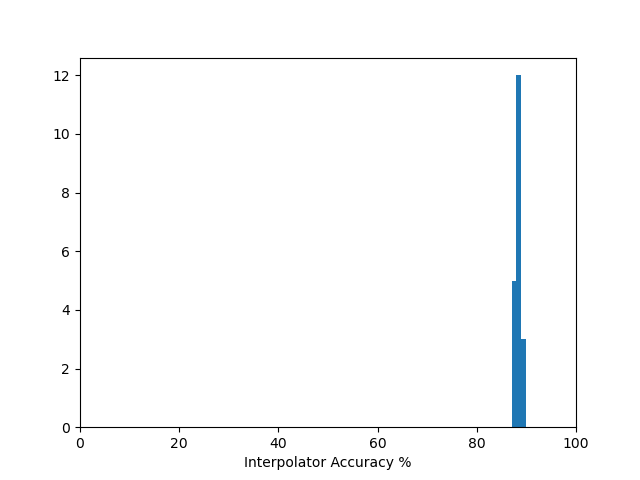

In [113]:
# intp_previous4 = np.copy(poly_uq.intp_errors)
# exceed_previous4 = np.copy(poly_uq.intp_exceed)
# undershot_previous4 = np.copy(poly_uq.intp_undershot)
plt.figure()
plt.hist(100-poly_uq.intp_errors*100, bins=np.arange(101))
# plt.hist(100-intp_previous1*100, bins=np.arange(101))
# plt.hist(100-intp_previous2*100, bins=np.arange(101))
plt.xlabel("Interpolator Accuracy %")
plt.xlim((0,100))
plt.show()
# print(poly_uq.intp_exceed[1] / poly_uq.intp_exceed[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# if poly_uq.intp_undershot[0]:
#     print(poly_uq.intp_undershot[1] / poly_uq.intp_undershot[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(poly_uq.imp_foc)
# print(exceed_previous1[1] / exceed_previous1[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(undershot_previous1[1] / undershot_previous1[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(exceed_previous2[1] / exceed_previous2[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(undershot_previous2[1] / undershot_previous2[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)

In [10]:
ray.shutdown()
ray.init(address='auto', _redis_password='5241590000000000')

all_intp_errors = {'damp_freqs':[None for _ in range(30)],'zetas':[None for _ in range(30)],'frf':[None for _ in range(30)]}
all_intp_exceed = {'damp_freqs':[None for _ in range(30)],'zetas':[None for _ in range(30)],'frf':[None for _ in range(30)]}
all_intp_undershot = {'damp_freqs':[None for _ in range(30)],'zetas':[None for _ in range(30)],'frf':[None for _ in range(30)]}

2023-01-27 09:50:08,562	INFO worker.py:1342 -- Connecting to existing Ray cluster at address: 141.24.193.47:6379...
2023-01-27 09:50:08,566	INFO worker.py:1519 -- Connected to Ray cluster. View the dashboard at 141.24.193.47:5990 


In [ ]:


# rets = test_interpolation('damp_freqs',{'modes':11},754)
# print(rets)

# asffdafgdf


@ray.remote
def sub_test(i, ret_name, i_n, N_mcs):
    if ret_name == 'frf':
        ret_ind = {'frequencies':i_n//2, 'space':i_n%2}
    else:
        ret_ind = {'modes':i_n}
    return i, ret_name, i_n, *test_interpolation(ret_name, ret_ind, N_mcs)

all_inds ={'damp_freqs':[],'zetas':[],'frf':[]}
all_MCS ={'damp_freqs':[],'zetas':[],'frf':[]}
futures = []
for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name == 'frf':
        n = 126*2
    else:
        n=14
        
    inds = np.random.randint(0,n,30)
    N_mcs = np.random.randint(100,3062,30)
    all_inds[ret_name] = inds
    all_MCS[ret_name] = N_mcs
    for i in range(30):
        if all_intp_errors[ret_name][i] is not None: continue
        futures.append(sub_test.remote(i, ret_name, inds[i], N_mcs[i]))

futures = set(futures)

In [ ]:
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=30)
    try:
        ret_sets = ray.get(ready)
        size_before = len(futures)
        for i, ret_name, ind, intp_errors, intp_exceed, intp_undershot in ret_sets:
        #     assert all_intp_errors[ret_name][i] is None
            all_intp_errors[ret_name][i] = intp_errors
        #     assert all_intp_exceed[ret_name][i] is None
            all_intp_exceed[ret_name][i] = intp_exceed
        #     assert all_intp_undershot[ret_name][i] is None
            all_intp_undershot[ret_name][i] = intp_undershot
            
        futures.difference_update(ready)
        print(f"Finished {len(ready)} samples. Remaining {len(futures)} samples. (before {size_before})")
    except Exception as e:
        print(e)
        pass
    if len(futures) == 0:
        break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
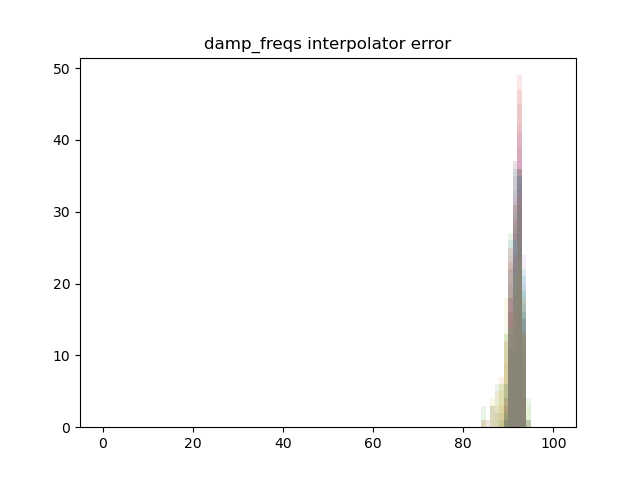

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
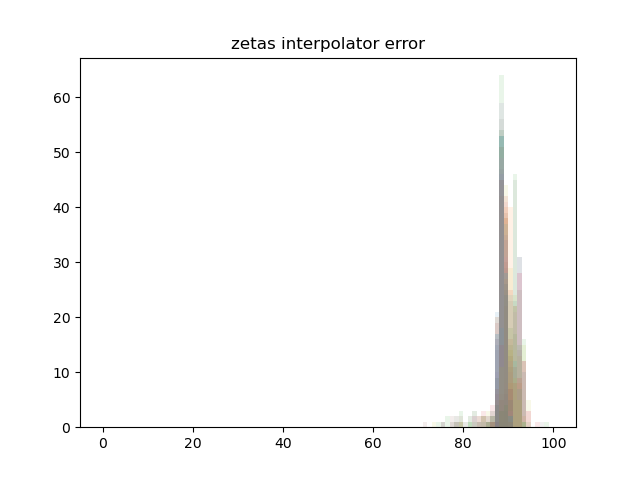

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
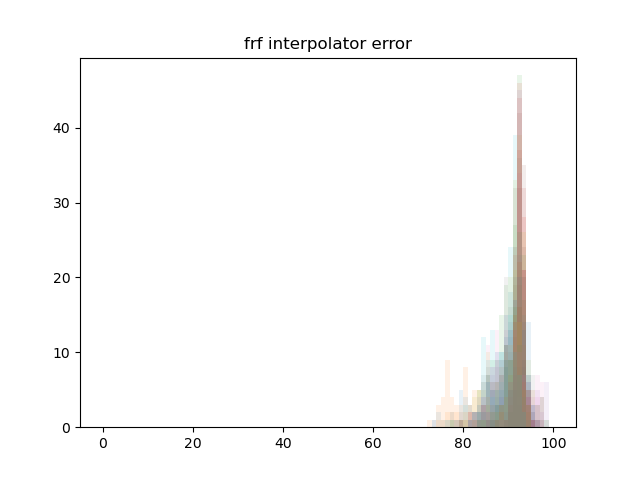

In [123]:
plt.close('all')
for ret_name in ['damp_freqs','zetas','frf']:
    '''
    draw 30 histograms of intp_errors (overlaying transparent)
    draw histogram of average exceed / undershot percent
    '''
    this_intp_errors = all_intp_errors[ret_name]
    plt.figure()
    for intp_errors in this_intp_errors:
        if intp_errors is None: continue
        plt.hist(100-intp_errors*100, bins=np.arange(101), alpha=0.1)
        
    plt.title(ret_name + ' interpolator error')
    plt.savefig('nearest ' + ret_name + ' interpolator error')
    continue
    all_undershots = []
    num_undershots = []
    for undershot in all_intp_undershot[ret_name]:
        if undershot is None: continue
        all_undershots.append(undershot[1] / undershot[0])
        num_undershots.append(undershot[0])
    plt.figure()
    plt.hist(all_undershots, weights= num_undershots)
    plt.title(ret_name + ' undershot error')
    plt.savefig('nearest ' + ret_name + ' undershot error')
#     plt.figure()
#     plt.hist(num_undershots)
#     plt.title(ret_name + ' undershot numbers')
    all_exceeds = []
    num_exceeds = []
    for exceed in all_intp_exceed[ret_name]:
        if exceed is None: continue
        all_exceeds.append(exceed[1] / exceed[0])
        num_exceeds.append(exceed[0])
    plt.figure()
    plt.hist(all_exceeds, weights= num_exceeds)
    plt.title(ret_name + ' exceed error')
    plt.savefig('nearest ' + ret_name + ' exceed error')
#     plt.figure()
#     plt.hist(num_exceeds)
#     plt.title(ret_name + ' exceed numbers')
    

### variability and incompleteness

In [ ]:
def stat_fun(a, weight,i_stat):
    return np.average(a, weights=weight)
n_stat = 1

# def stat_fun(a, weight, i_stat):
#     n = len(a)
#     mean = np.average(a, weights=weight)
#     std = np.sqrt(np.cov(a, aweights=weight))
#     if std==0:
#         conf= [mean, mean]
#     else:
#         sem = std / np.sqrt(n)
#         conf = scipy.stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=sem) 
#     if i_stat is not None:
#         return conf[i_stat]
#     else: 
#         return conf

# n_stat = 2
# focals_stats, hyc_mass = poly_uq.estimate_inc(stat_fun, n_stat)
focals_stats, hyc_mass = poly_uq.optimize_inc(stat_fun, n_stat)
# poly_uq.save_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))

bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, hyc_mass, 10, False)
n_bins_bel = bins_bel.shape[0]

In [ ]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name == 'frf':
        continue
        #frequencies = np.arange(2048)
        all_focals = []
        space_ind = 3
        for freq_ind in range(1025):
            ret_ind = {'frequencies':freq_ind, 'space':space_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            arr = np.load(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz'))
#             poly_uq.load_state(f'/usr/scratch4/sima9999/work/modal_uq/uq_modal/{ret_dir}/polyuq_avg_inc.npz')
            focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']
            all_focals.append(focals_stats)
            
        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(np.stack([foc[0,:,:] for foc in all_focals]),focals_mass)
        n_bins_bel = bel_stats.shape[1]
        cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
        plt.figure()
        im = plt.imshow(pl_stats.T, aspect='auto', extent= (0, 5, np.min(focals_stats), np.max(focals_stats)),
                        cmap=cmap, origin='lower')
        
        
    else:
#         continue
#         fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
        fig, ax1 = plt.subplots()
            
        for mode_ind in range(14):
            ret_ind = {'modes':mode_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            
#             poly_uq.load_state(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_lci_inc.npz'))
#             focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
#             if False:
#                 plot_focals(focals_stats[0,:,:], focals_mass, ax2)
#             else:
#                 bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 1, False)
#                 ax2.step(bins_bel, pl_stats[0], where='post',label='plausibility ')
            
            poly_uq.load_state(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz'))
            focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
            
            if False:
                plot_focals(focals_stats[0,:,:], focals_mass, ax1)
            else:
                bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
                ax1.step(bins_bel, pl_stats[0], where='post',label='plausibility ')




            
# plt.step(bins_bel, bel_stats[0], where='post',label='belief')
# plt.step(bins_bel, bel_stats[1], where='post',label='belief')
# plt.step(bins_bel, pl_stats[0], where='post',label='plausibility ')
# plt.step(bins_bel, pl_stats[1], where='post', c='grey')
# plt.step(bins_bel, pl_stats[0], where='post', c='grey')
# plt.fill_between(bins_bel, pl_stats[0], pl_stats[1], step='post',label='plausibility', color='lightgrey')
# plt.step(bins_bel, q_stats[0], where='post',label='commonality')
# plt.legend()
# plt.xlabel(f"{ret_dir}")
# plt.ylabel("mass")
# None

In [ ]:
all_focals_this = np.stack([foc[0,:,:] for foc in all_focals])
# all_focals_this /= np.max(all_focals_this)
all_focals_this[all_focals_this<=1e-3] = 1e-3
all_focals_this[all_focals_this>80] = 80
# all_focals_this = 10*np.log10(all_focals_this)
bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(all_focals_this,focals_mass,1)
np.savez('/usr/scratch4/sima9999/frf_pl.npz', all_focals_this, bel_stats, pl_stats, q_stats, bins_bel)
n_bins_bel = bel_stats.shape[1]
cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
with matplotlib.rc_context(print_context_dict2):
    plt.figure()
    print(np.min(all_focals_this), np.max(all_focals_this))
    im = plt.imshow(pl_stats.T, aspect='auto', extent= (0, 200, np.min(all_focals_this), np.max(all_focals_this)),
                    cmap=cmap, origin='lower', vmin=0, vmax=1)
    plt.xlabel('Frequency [\\si{\\hertz}]')
    plt.ylabel('FRF Magnitude [\\si{\\metre\\per\\second\\squared}]')

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_lci_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-1/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-2/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/zetas-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima99

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
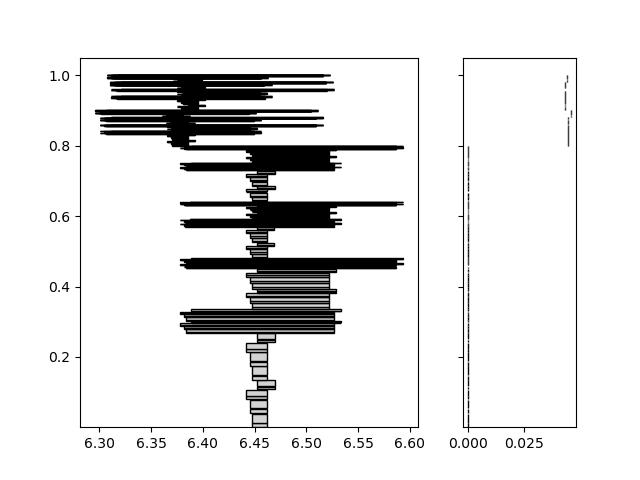

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
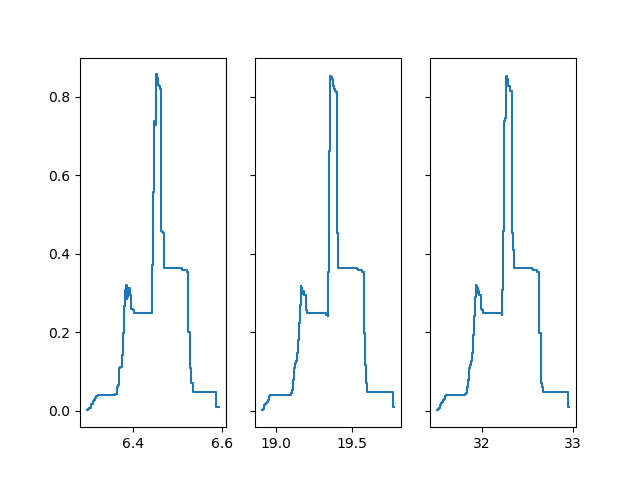

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
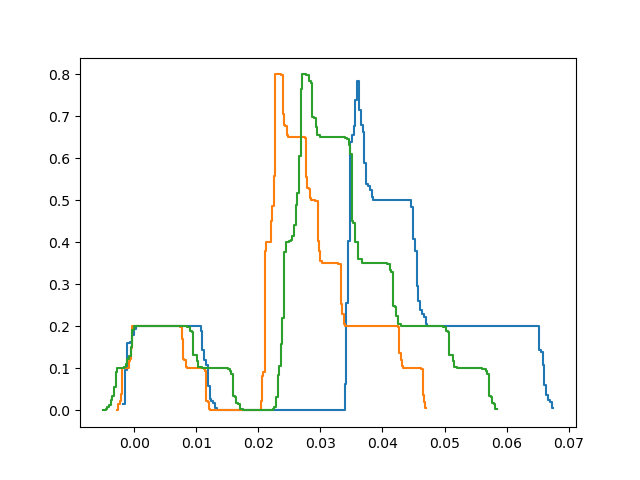

In [19]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

if 0:
    fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
    ret_name='damp_freqs'
    ret_ind = {'modes':0}
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_lci_inc.npz'))
    focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
    plot_focals(focals_stats[0,:,:], focals_mass, ax2)

    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
    focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
    plot_focals(focals_stats[0,:,:], focals_mass, ax1)
    
if 1:
    fig, axes = plt.subplots(1,3, sharey=True)
    ret_name='damp_freqs'
    for mode_ind,ax in enumerate(axes):
        ret_ind = {'modes':mode_ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
        focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
        ax.step(bins_bel, pl_stats[0], where='post',label='plausibility')

if 1:
    fig, ax = plt.subplots(1,1, sharey=True)
    ret_name='zetas'
    for mode_ind in range(3):
        ret_ind = {'modes':mode_ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
        focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
        ax.step(bins_bel, pl_stats[0], where='post',label='plausibility')

In [21]:
# ret_name = 'frf'
# space_ind = 9
# freq_ind = 100
# ret_ind = {'frequencies':freq_ind, 'space':space_ind}
ret_name = 'damp_freqs'
# ret_name = 'zetas'
mode_ind = 0
ret_ind = {'modes':mode_ind}

ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

if True:
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_imp.npz'))
    
    def stat_fun(a, weight, i_stat, bins_densities, cum_dens):
        '2. Quantify Variability for each incomplete sample and imprecise hypercube'
        if i_stat is None:
            hist,_ = np.histogram(a, bins_densities, weights=weight, density=True)

            if cum_dens:
                hist= np.cumsum(hist)
                hist /= hist[-1]   
            return hist
        else:
            # factor 6 faster but more error prone for "dirty" data, uneven bins or ....
            if cum_dens: first_edge = bins_densities[0]
            else: first_edge = bins_densities[i_stat]
            last_edge = bins_densities[i_stat + 1]
            keep  = (a >= first_edge)
            keep &= (a <=  last_edge)
            return np.sum(weight[keep])


    nbin_fact=20
    n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
    bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
    n_stat = len(bins_densities) - 1
    cum_dens = False
    stat_fun_kwargs = {'bins_densities':bins_densities, 'cum_dens':cum_dens}#, 'ax':ax1}

    # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
    focals_stats, focals_mass = poly_uq.optimize_inc(stat_fun, n_stat, stat_fun_kwargs)
    # poly_uq.save_state(os.path.join(result_dir,f'{ret_dir}/polyuq_hist_inc.npz'))
else:
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_hist_inc.npz'))
    
    nbin_fact=20
    n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
    bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
    cum_dens = True
    
    focals_stats = poly_uq.focals_stats
    focals_mass = poly_uq.focals_mass

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_imp.npz
INFO:uncertainty.polymorphic_uncertainty:Estimating incompleteness intervals by direct L-BFGS optimization of statistics over input hypercubes...


/usr/wrk/people9/sima9999/my-python/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


....................................................................................................


In [24]:
focals_stats = focals_densities
focals_mass = hyc_mass
bel_densities, pl_densities, q_densities, bins_bel = aggregate_mass(focals_stats, focals_mass, 20, False)
n_bins_bel = bel_densities.shape[1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
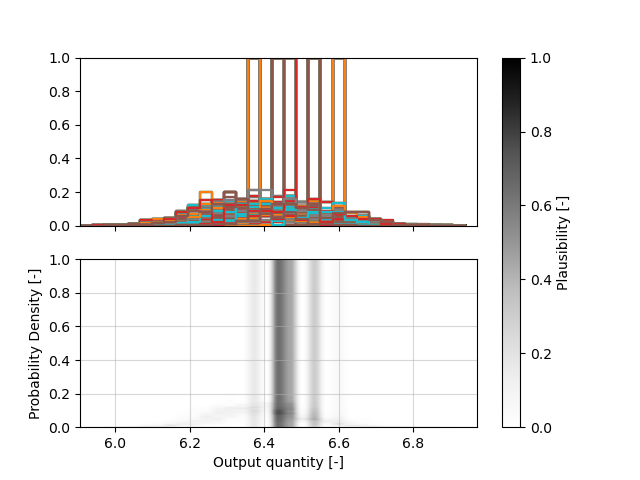

In [25]:

bpq=2

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True)   

for i_hyc in range(hyc_mass.shape[0]):
    l2d=ax1.step(bins_densities[:-1], focals_stats[:,i_hyc, 0], where='post')
    c = l2d[0].get_color()
    ax1.step(bins_densities[:-1], focals_stats[:,i_hyc, 1], where='post', color=c)

if bpq == 1:
    belief = bel_densities.T
    label = 'Belief [-]'
elif bpq == 2:
    belief = pl_densities.T
    label = 'Plausibility [-]'
elif bpq == 3:
    belief = q_densities.T
    label = 'Commonality [-]'

cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
im = ax2.imshow(belief, aspect='auto', extent= (bins_densities[0], bins_densities[-1], 0, 1), 
           cmap=cmap, origin='lower', vmin=0, vmax=1)

cbar = fig.colorbar(im, ax=[ax1,ax2])
cbar.set_label(label)

ax2.grid(True, alpha=0.5)
ax2.set_xlabel("Output quantity [-]")

if cum_dens:
    ax2.set_ylabel("Cumulative Probability Density [-]")
else:
    ax2.set_ylabel("Probability Density [-]")    

## distributed quantification (ray) ###

In [5]:
ray.shutdown()

In [6]:
ray.init(address='auto', _redis_password='5241590000000000')
futures = []
remote_opt_inc = ray.remote(num_cpus=1)(opt_inc)
remote_est_imp = ray.remote(num_cpus=4)(est_imp)
remote_est_stoch = ray.remote(num_cpus=1)(est_stoch)

2023-04-19 14:52:08,687	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 141.24.193.47:6379...
2023-04-19 14:52:08,699	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 141.24.193.47:5990 


In [ ]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)

def submit_imp():
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    fname = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
    if not os.path.exists(fname) or True:
        futures.append(remote_est_imp.remote(poly_uq, result_dir, ret_name, ret_ind))
    else:
        
        intp_err = np.load(fname)['self.intp_errors']
        nan_ind = np.where(np.isnan(intp_err))[0]
        if not len(nan_ind):
            print(f'{ret_dir}/polyuq_imp.npz already finished.')
            return # finished
        elif np.min(nan_ind)>=5390: # should not be the case
            print(f'{ret_dir}/polyuq_imp.npz already finished.')
            return # finished
        else:
            futures.append(remote_est_imp.remote(poly_uq, result_dir, ret_name, ret_ind))
        

def submit_inc():
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    fname = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_avg_inc.npz')
    if not os.path.exists(fname) or True:
        futures.append(remote_opt_inc.remote(poly_uq, result_dir, ret_name, ret_ind))
    else:
        print(f'{ret_dir}/polyuq_avg_inc.npz already finished.')
        
def submit_stoch():
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    fname = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_hist_stoch.npz')
    if not os.path.exists(fname) or True:
        futures.append(remote_est_stoch.remote(poly_uq, result_dir, ret_name, ret_ind))
    else:
        print(f'{ret_dir}/polyuq_hist_stoch.npz already finished.')

   
    
def submit():
    # submit_imp()
    # submit_inc()
    submit_stoch()
    
if False:
    futures = list(futures)
else:
    futures = []


for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name != 'frf':
        # continue
        for mode_ind in range(14):
            ret_ind = {'modes':mode_ind}
            # est_stoch(poly_uq, result_dir, ret_name, ret_ind)
            submit()
    else:
        # continue
        for freq_ind in range(1025):
            for space_ind in [2,1]:
                ret_ind = {'frequencies':freq_ind, 'space':space_ind}
                submit()
futures = set(futures)

In [ ]:
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=60)
    finished = []
    failed = []
    for obj_ref in ready:
        try:
            ret_sets = ray.get(obj_ref)
            finished.append(obj_ref)
        except ray.exceptions.RayTaskError as e:
            print(e)
            failed.append(obj_ref)
    
    size_before = len(futures)
    futures.difference_update(finished)
    futures.difference_update(failed)
    print(f"Finished {len(finished)}, failed {len(failed)} samples. Remaining {len(futures)} samples. (before {size_before})")
        
    if len(futures) == 0:
        break

### Evidential Probability Density Estimation

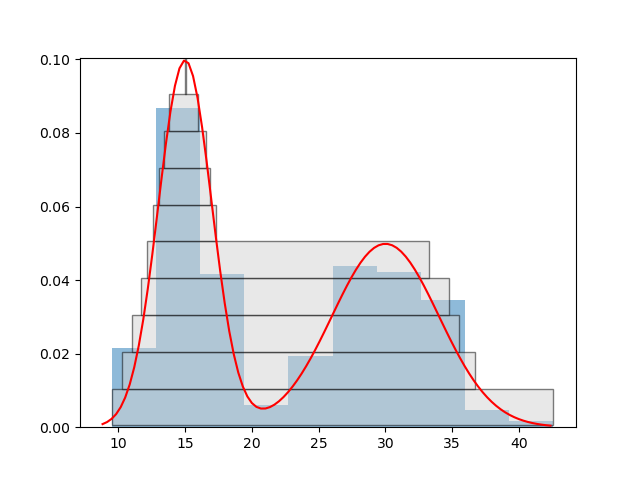

In [126]:
m=15
s=2
size=717

plt.close('all')
plt.figure()
norm = scipy.stats.norm(m,s)
x = np.linspace(norm.ppf(0.001),scipy.stats.norm(2*m,2*s).ppf(0.999), 100)

plt.plot(x, norm.pdf(x)/2+scipy.stats.norm(2*m,2*s).pdf(x)/2, 'r-')

samp = np.concatenate([norm.rvs(size//2),scipy.stats.norm(2*m,2*s).rvs(size//2+size%2)])

samp = np.sort(samp)

# kernel density estimation
# kde = scipy.stats.gaussian_kde(samp)
# plt.plot(x, kde(x), 'b-')

#histogram
plt.hist(samp, bins='fd',density=True, cumulative=False, alpha=0.5)

# sliding bin histogram
ntot = len(samp)
bin_width=(samp[-1]-samp[0])*0.05
bin_width = np.diff(np.quantile(samp,[0.25,0.75]))/np.power(ntot,1/3)*2
bin_centers, densities = np.zeros(len(samp)), np.zeros(len(samp))
for n in range(ntot):
    ind = np.logical_and(samp > (samp[n] - bin_width / 2), samp < (samp[n] + bin_width / 2))
    p = np.sum(ind) / bin_width / ntot
    bin_centers[n] = samp[n]
    densities[n] = p
# plt.plot(bin_centers, densities, ls='none',marker=',')

target_pdfs = np.linspace(0,1,101)
intervals = np.zeros((target_pdfs.shape[0],2))

for j in range(target_pdfs.shape[0]):
    target_pdf = target_pdfs[j]
    for k,min_max in enumerate([-1,1]):# maximum: -1, minimum: 1
        it = range(len(densities))
        if min_max==-1:
            it = reversed(it)
        for i in it:
            if densities[i]>target_pdf:
                break
        else:
            intervals[j,k] = np.nan
            continue
        # intervals[j,k] = bin_centers[i]
        # continue
        if i <= 1:
            intervals[j,k] = bin_centers[i]
        elif i >= densities.shape[0] - 1:
            intervals[j,k] = bin_centers[-1]
        else:
            if min_max==-1:
                intervals[j,k] = (bin_centers[i]*(densities[i+1] - target_pdf) + bin_centers[i+1]*(target_pdf - densities[i]))/(densities[i+1] - densities[i])
            else:
                intervals[j,k] = (bin_centers[i - 1]*(densities[i] - target_pdf) + bin_centers[i]*(target_pdf - densities[i-1]))/(densities[i] - densities[i-1])

cm = 0
for j in range(target_pdfs.shape[0]):
    r,l = intervals[j,:]
    m = target_pdfs[1]-target_pdfs[0]
    plt.bar(l,m,(r-l),bottom = cm+0.05*m, align='edge', color='lightgrey', edgecolor='black', alpha=0.5)
    cm += m
   

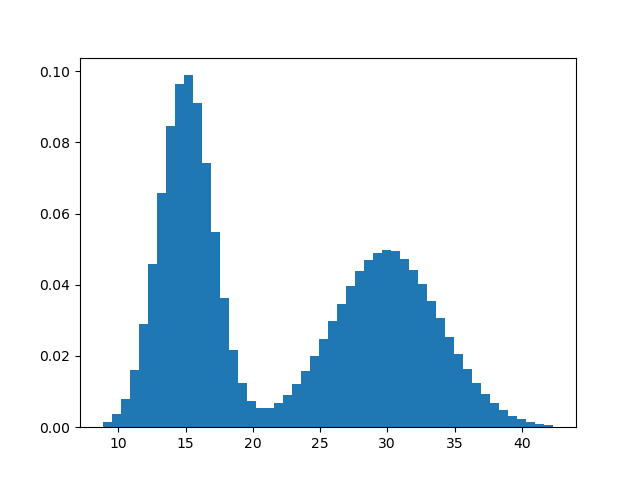

In [193]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)


m1=15
s1=2
m2=2*m1
s2=2*s1
size=13717


norm1 = scipy.stats.norm(m1,s1)
norm2 = scipy.stats.norm(m2,s2)

import scipy.stats.qmc
supp1 = [norm1.ppf(0.001), norm1.ppf(0.999)]
supp2 = [norm2.ppf(0.001), norm2.ppf(0.999)]

engine = scipy.stats.qmc.Halton(2)
samp = engine.random(size) # (size,2)
# samp = scipy.stats.qmc.scale(samp,(supp1[0],supp2[0]),(supp1[1],supp2[1]))
samp = scipy.stats.qmc.scale(samp,(supp1[0],supp1[0]),(supp2[1],supp2[1]))

pdf1 = norm1.pdf(samp[:,0])
pdf2 = norm2.pdf(samp[:,0])
pdf = pdf1 + pdf2
pdf /= np.sum(pdf)

# x = np.concatenate((samp[:,0], samp[:,1]))
samp = samp[:,0] #+ samp[:,1]
# x = np.random.choice(samp.flat, samp.shape[0])

def density(samp, weights, i_stat, min_max, target_densities, bin_width=None):
    ind = np.argsort(samp)
    samp = samp[ind]
    weights = weights[ind]
    
    if min_max == -1:
        samp = np.flip(samp)
        weights = np.flip(weights)
        
    N_mcs_ale = len(samp)
    target_p = target_densities[i_stat]
    if bin_width is None: # should probably be fixed prior to optimize_inc. how?
        quantiles = weighted_quantile(samp, [0.25,0.75], weights,True)
        bin_width = np.diff(quantiles)/np.power(len(N_mcs_ale),1/3) * 2 # fd rule
    p_prev = 0
    it = range(N_mcs_ale)
    # if min_max==-1:
    #     it = reversed(it)
    for n in it:
        '''
        looking for a contiguous sequence of weights, that is >= target_p * bin_width
        maybe there is another way of finding that sequence
        two variables determine p
        the density of samp in a given sequence and the values of weights
        if diff(samp) is small, we have a high density
        
        we want to find a stopping criterion, to stop early, if no density with requested value is present in the dataset
        problem is, there can always be an accumulation of samples at any point in the sequence which leads to a high density
        
        pre-computation by vectorization will lead to and ind matrix of size 13717x13717 -> also not an option
        bisection or random searches might also just miss the single bin, that has the highest density
        we have to extend optimize_inc such that we can select a range of i_stat to perform optimzation on and extend that later, 
        if we realize, we are missing the peaks of the distribution
        the optimizer will also fail, if wrapper returns 0 all the time, that might be an option for breaking the loop early
        '''
        ind = np.logical_and(samp > (samp[n] - bin_width / 2), samp < (samp[n] + bin_width / 2))
        p_curr = np.sum(weights[ind]) / bin_width #/ ntot
        if p_curr > target_p:
            break
        p_prev = p
    else: # did not find a bin with target density
        return np.nan
    # return samp[n]
    if n == 0:
        return samp[n]
    # if n == N_mcs_ale - 1:
    #     return samp[n]
    
    # interpolate between two bins
    # elif min_max==-1: # walking backwards -> interpolating from the end
    #     x0, x1 = p_prev, p_curr
    #     y0, y1 = samp[n + 1], samp[n]
    # else:
    x0, x1 = p_prev, p_curr
    y0, y1 = samp[n - 1], samp[n]
        
    return (y0 * (x1 - target_pdf) + y1 * (target_pdf - x0))/(x1 - x0)
         

ind = np.argsort(samp)
samp = samp[ind]
pdf = pdf[ind]
plt.close('all')
plt.figure()
# plt.plot(samp, pdf, ls='none', marker=',')
plt.hist(samp, 
         weights=pdf, 
         density=True,
        bins=50)
pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


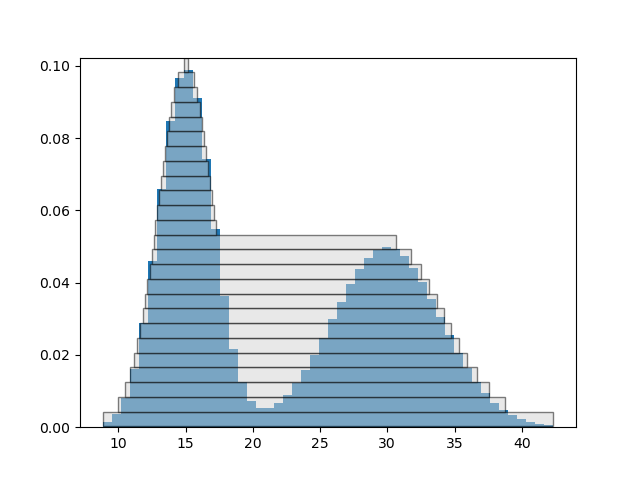

In [194]:
plt.close('all')
plt.figure()
# plt.plot(samp, pdf, ls='none', marker=',')
plt.hist(samp, 
         weights=pdf, 
         density=True,
        bins=50)
# plt.hist(norm1.rvs(size)+norm2.rvs(size), bins=50, alpha=0.5, density=True)
# sliding bin histogram

target_pdfs = np.linspace(0,0.2,50)
intervals = np.full((target_pdfs.shape[0],2),np.nan)

ntot = len(samp)
quantiles = weighted_quantile(samp, [0.25,0.75], pdf,True)
bin_width = np.diff(quantiles)/np.power(ntot,1/3)*2

for i_stat in range(target_pdfs.shape[0]):
    print(i_stat)
    for k, min_max in enumerate([-1,1]):
        intervals[i_stat,k] = density(samp, pdf, i_stat, min_max, target_pdfs, bin_width)
    if np.isnan(intervals[i_stat,:]).all():
        break

                
cm = 0
for j in range(target_pdfs.shape[0]):
    r,l = intervals[j,:]
    m = target_pdfs[1]-target_pdfs[0]
    plt.bar(l,m,(r-l),bottom = cm+0.05*m, align='edge', color='lightgrey', edgecolor='black', alpha=0.5)
    cm += m

In [195]:
# plt.figure()
# plt.plot(samp, pdf, ls='none', marker=',')
plt.hist(samp, 
         weights=pdf, 
         density=True,
        bins=50, 
        alpha=0.5)
# plt.hist(norm1.rvs(size)+norm2.rvs(size), bins=50, alpha=0.5, density=True)
# sliding bin histogram

bin_centers, densities = np.zeros(len(samp)), np.zeros(len(samp))
for n in range(ntot):
    ind = np.logical_and(samp > (samp[n] - bin_width / 2), samp < (samp[n] + bin_width / 2))
    p = np.sum(pdf[ind]) / bin_width #/ ntot
    bin_centers[n] = samp[n]
    densities[n] = p
# plt.plot(bin_centers, densities, ls='none',marker=',')

for j in range(target_pdfs.shape[0]):
    target_pdf = target_pdfs[j]
    for k,min_max in enumerate([-1,1]):# maximum: -1, minimum: 1
        it = range(len(densities))
        if min_max==-1:
            it = reversed(it)
        for i in it:
            if densities[i]>target_pdf:
                break
        else:
            intervals[j,k] = np.nan
            continue
            
        # intervals[j,k] = bin_centers[i]
        # continue
        if i <= 1:
            intervals[j,k] = bin_centers[i]
        elif i >= densities.shape[0] - 1:
            intervals[j,k] = bin_centers[-1]
        else:
            if min_max==-1:
                intervals[j,k] = (bin_centers[i]*(densities[i+1] - target_pdf) + bin_centers[i+1]*(target_pdf - densities[i]))/(densities[i+1] - densities[i])
            else:
                intervals[j,k] = (bin_centers[i - 1]*(densities[i] - target_pdf) + bin_centers[i]*(target_pdf - densities[i-1]))/(densities[i] - densities[i-1])


                
cm = 0
for j in range(target_pdfs.shape[0]):
    r,l = intervals[j,:]
    m = target_pdfs[1]-target_pdfs[0]
    plt.bar(l,m,(r-l),bottom = cm+0.05*m, align='edge', color='lightgrey', edgecolor='black', alpha=0.5)
    cm += m